# Part 1- Sentiment analysis of stock news

## Import the libraries

In [247]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
from newsapi import NewsApiClient
from datetime import datetime, timedelta
from dotenv import load_dotenv
load_dotenv()

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Fetch the stock OHLC

In [4]:
# Yahoo finance is used
stock_data= yf.download(tickers= 'MSFT', period= '5y')
stock_data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,222.529999,223.000000,214.809998,217.690002,217.690002,37130100
2021-01-05,217.259995,218.520004,215.699997,217.899994,217.899994,23823000
2021-01-06,212.169998,216.490005,211.940002,212.250000,212.250000,35930700
2021-01-07,214.039993,219.339996,213.710007,218.289993,218.289993,27694500
2021-01-08,218.679993,220.580002,217.029999,219.619995,219.619995,22949400


In [205]:
# Get only the closing price and round to 2 decimals
stock_close= round (stock_data['Close'], 2)
stock_close.tail()

Date
2016-01-15    50.99
2016-01-14    53.11
2016-01-13    51.64
2016-01-12    52.78
2016-01-11    52.30
Name: Close, dtype: float64

In [196]:
# Calculate the daily returns
returns= stock_close.pct_change()*100
returns.tail()

Date
2016-01-15    0.850475
2016-01-14    4.157678
2016-01-13   -2.767840
2016-01-12    2.207591
2016-01-11   -0.909435
Name: Close, dtype: float64

In [197]:
# Convert to a dataframe and sort by descending date
returns_df= pd.DataFrame(returns)
returns_df.sort_index(ascending= False, inplace= True)

returns_df.rename(columns= {'Close':'pct_change'}, inplace= True)
returns_df.head()

,pct_change
Date,
2021-01-08,NaN
2021-01-07,-0.605591
2021-01-06,-2.766961
2021-01-05,2.661955
2021-01-04,-0.096374


### Download the VADER Lexicon

In [8]:
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
analyzer= SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sathe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Fetch the news

In [62]:
# Import the libraries
import requests
import json

In [63]:
# Check for the STOCK_NEWS_API key
stock_news_api= os.getenv("STOCK_NEWS_API")
type (stock_news_api)

str

In [64]:
# Define the base request URL
request_url = "https://stocknewsapi.com/api/v1?tickers=MSFT&items=50&token="

# Concatenate request_url and api_key. Store as new variable
request_url= request_url+ stock_news_api

In [65]:
# Execute get request
response_data= requests.get(request_url).json()

In [234]:
# Print the response data
print (json.dumps (response_data, indent= 4))

{
    "data": [
        {
            "news_url": "https://www.fool.com/investing/2021/01/08/is-microsoft-stock-a-buy/",
            "image_url": "https://cdn.snapi.dev/images/v1/m/5/104726953-microsoft-satya-nadella-2-high-res530x298.jpg",
            "title": "Is Microsoft Stock a Buy?",
            "text": "Despite already being a $1.6 trillion company, Microsoft has a few tricks up its sleeve to grow even more.",
            "source_name": "The Motley Fool",
            "date": "Fri, 08 Jan 2021 08:15:00 -0500",
            "topics": [],
            "sentiment": "Positive",
            "type": "Article",
            "tickers": [
                "MSFT"
            ]
        },
        {
            "news_url": "https://www.businessinsider.com/faang-stocks-rebound-after-democratic-wins-georgia-shake-big-tech-2021-1",
            "image_url": "https://cdn.snapi.dev/images/v1/f/a/faang-stocks-rebound-after-democratic-wins-in-georgia-shake-big-tech.jpg",
            "title": "FAANG stoc

## Get the news text, date and the sentiment from response data

In [229]:
def combined_df(text):
    all_articles= []
    all_sentiments= []
    all_dates= []
    for article in response_data['data']:
        all_articles.append(article['text'])
        all_sentiments.append(article['sentiment'])
        all_dates.append(article['date'])
        text_sentiment= pd.concat([all_dates_df, all_articles_df, all_sentiments_df], axis= 1)
    return text

In [232]:
combined_df(text_sentiment).head()

,date,text,sentiment
0,2021-01-08,"Despite already being a $1.6 trillion company,...",Positive
1,2021-01-07,Jon Ossoff and Raphael Warnock pulled off narr...,Positive
2,2021-01-07,It's been an ugly start to 2021 for Microsoft ...,Positive
3,2021-01-07,"With bitcoin touching new highs, it's imperati...",Positive
4,2021-01-06,"Dick Costolo, 01 Advisors managing partner and...",Negative


In [235]:
# Set the date as index
text_sentiment.set_index('date', inplace= True)
text_sentiment.head()

,text,sentiment
date,,
2021-01-08,"Despite already being a $1.6 trillion company,...",Positive
2021-01-07,Jon Ossoff and Raphael Warnock pulled off narr...,Positive
2021-01-07,It's been an ugly start to 2021 for Microsoft ...,Positive
2021-01-07,"With bitcoin touching new highs, it's imperati...",Positive
2021-01-06,"Dick Costolo, 01 Advisors managing partner and...",Negative


In [236]:
# Merge the pct change with the above df
text_sentiment_returns= pd.merge(text_sentiment, returns_df, left_index= True, right_index= True)
text_sentiment_returns.sort_index(ascending= False, inplace= True)
text_sentiment_returns.head()

,text,sentiment,pct_change
2021-01-08,"Despite already being a $1.6 trillion company,...",Positive,NaN
2021-01-07,"With bitcoin touching new highs, it's imperati...",Positive,-0.605591
2021-01-07,It's been an ugly start to 2021 for Microsoft ...,Positive,-0.605591
2021-01-07,Jon Ossoff and Raphael Warnock pulled off narr...,Positive,-0.605591
2021-01-06,The Georgia Senate runoffs remain too close to...,Negative,-2.766961


In [237]:
text_sentiment_returns.reset_index(inplace= True)
text_sentiment_returns.head()

,index,text,sentiment,pct_change
0,2021-01-08,"Despite already being a $1.6 trillion company,...",Positive,NaN
1,2021-01-07,"With bitcoin touching new highs, it's imperati...",Positive,-0.605591
2,2021-01-07,It's been an ugly start to 2021 for Microsoft ...,Positive,-0.605591
3,2021-01-07,Jon Ossoff and Raphael Warnock pulled off narr...,Positive,-0.605591
4,2021-01-06,The Georgia Senate runoffs remain too close to...,Negative,-2.766961


### Create the sentiment scores DF

In [238]:
polarity= []

for content in text_sentiment['text']:
    try:
        # Calculate the polarity score
        sentiment= analyzer.polarity_scores(content)
        compound= sentiment['compound']
#         positive= sentiment['pos']
#         negative= sentiment['neg']
#         neutral= sentiment['neu']
        
        polarity.append({
            "compound": compound,
#             "positive": positive,
#             "negative": negative,
#             "neutral": neutral
        })
        
    except AttributeError:
        pass
    
# Create dataframe
polarity_df= pd.DataFrame(polarity)
polarity_df.head()

,compound
0,-0.1280
1,-0.0772
2,0.8765
3,0.3612
4,-0.5106


In [239]:
text_sentiment_returns_polarity= pd.concat([text_sentiment_returns, polarity_df], axis= 1)
text_sentiment_returns_polarity.head()

,index,text,sentiment,pct_change,compound
0,2021-01-08,"Despite already being a $1.6 trillion company,...",Positive,NaN,-0.1280
1,2021-01-07,"With bitcoin touching new highs, it's imperati...",Positive,-0.605591,-0.0772
2,2021-01-07,It's been an ugly start to 2021 for Microsoft ...,Positive,-0.605591,0.8765
3,2021-01-07,Jon Ossoff and Raphael Warnock pulled off narr...,Positive,-0.605591,0.3612
4,2021-01-06,The Georgia Senate runoffs remain too close to...,Negative,-2.766961,-0.5106


## Tokenization, Lemmatization

In [165]:
# Importing the Libraries and Functions
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [166]:
# Instantiate the lemmatizer
lemmatizer= WordNetLemmatizer()

In [167]:
def tokenizer(text):
    """Tokenizes text."""
    
    # Remove the stop words
    stop_words= set (stopwords.words('english'))
   
    # Remove the punctuation and substitute
    non_alpha= re.compile('[^a-zA-Z ]')
    re_clean= non_alpha.sub('', str (text))
    
    # Tokenize the words
    words= word_tokenize(re_clean)
    
    # Lemmatize Article words into root words
    root_words= []
    for values in words:
        root_words.append(lemmatizer.lemmatize(values))
        
    # Remove stop words and Convert the words to lowercase
    tokens= []
    for all_words in root_words:
        if all_words.lower() not in stop_words:
            tokens.append(all_words.lower())
    
    return tokens

In [168]:
# Apply the tokenizer function to the news text column
text_sentiment_returns_polarity['tokenized']= text_sentiment_polarity['text'].apply(tokenizer)
text_sentiment_returns_polarity.head()

,index,text,sentiment,pct_change,compound,tokenized
0,2021-01-08,"Despite already being a $1.6 trillion company,...",Positive,0.005955,-0.1280,"[despite, already, trillion, company, microsof..."
1,2021-01-07,"With bitcoin touching new highs, it's imperati...",Positive,0.028746,-0.0772,"[jon, ossoff, raphael, warnock, pulled, narrow..."
2,2021-01-07,It's been an ugly start to 2021 for Microsoft ...,Positive,0.028746,0.8765,"[ugly, start, microsoft, stock, wary, investor..."
3,2021-01-07,Jon Ossoff and Raphael Warnock pulled off narr...,Positive,0.028746,0.3612,"[bitcoin, touching, new, high, imperative, wat..."
4,2021-01-06,The Georgia Senate runoffs remain too close to...,Negative,-0.026159,-0.5106,"[dick, costolo, advisors, managing, partner, f..."


## N-grams, WordCloud

In [80]:
# Import the libraries and functions
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15.0, 15.0]

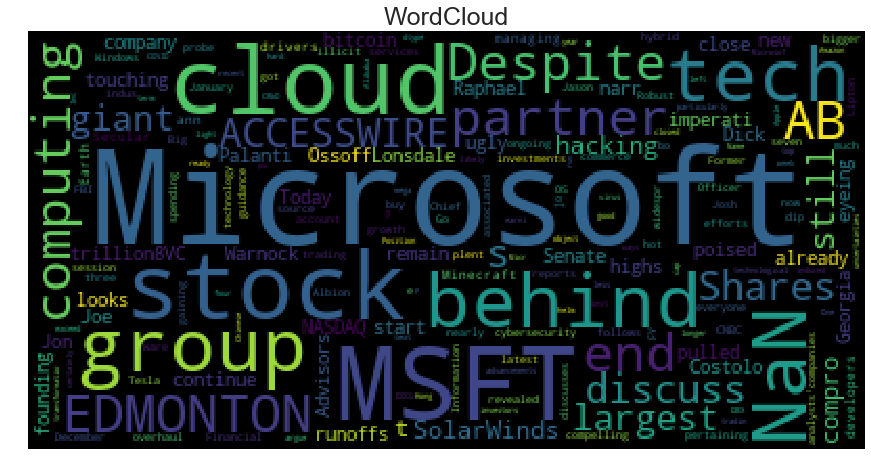

In [169]:
# Generate the word cloud
returns_big_text= ''.join (str (text_sentiment_returns_polarity["text"]))

returns_wc= WordCloud().generate(returns_big_text)

plt.imshow(returns_wc)
plt.axis("off")
plt.title('WordCloud', fontsize= 25)
plt.show()

# Part 2- Stock technical analysis

In [175]:
# Import the libraries
from ta import add_all_ta_features
from ta.utils import dropna

In [177]:
# The stock data for the last 5 years has been downloaded in the beginning
# Get the technical indicators
tech_indicators= add_all_ta_features(stock_data, open="Open", high="High", low="Low", close="Close", volume="Volume")
tech_indicators.head()

C:\Satheesh\Anaconda\envs\pyvizenv\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Satheesh\Anaconda\envs\pyvizenv\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-11,52.509998,52.849998,51.459999,52.299999,47.725410,36943800,7.707727e+06,36943800,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-52.920985,NaN,0.000000
2016-01-12,52.759998,53.099998,52.060001,52.779999,48.163425,36095500,2.159057e+07,73039300,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.917781,0.913595,0.917781
2016-01-13,53.799999,54.070000,51.299999,51.639999,47.123150,66883600,-2.887395e+07,6155700,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.159908,-2.183575,-1.261950
2016-01-14,52.000000,53.419998,51.570000,53.110001,48.464577,52381900,5.953063e+06,58537600,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.846633,2.806869,1.548760
2016-01-15,51.310001,51.970001,50.340000,50.990002,46.530006,71820700,-8.587227e+06,-13283100,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.991713,-4.073568,-2.504775


In [181]:
tech_indicators.tail()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,222.529999,223.000000,214.809998,217.690002,217.690002,37130100,2.681300e+09,2588805600,0.065886,-1.773292e+07,...,-63.520739,6.345734,219.578230,1.662540,-4.410721,-4.049526,-0.361195,-2.126605,-2.149543,316.233280
2021-01-05,217.259995,218.520004,215.699997,217.899994,217.899994,23823000,2.694648e+09,2612628600,0.086943,-1.448499e+07,...,-62.115172,4.823911,219.566349,-0.629335,-4.682561,-4.176133,-0.506428,0.096464,0.096417,316.634794
2021-01-06,212.169998,216.490005,211.940002,212.250000,212.250000,35930700,2.663613e+09,2576697900,0.029176,-4.141688e+07,...,-97.965894,2.647236,218.733676,-3.267705,-1.160800,-3.573066,2.412266,-2.592930,-2.627139,305.831746
2021-01-07,214.039993,219.339996,213.710007,218.289993,218.289993,27694500,2.680977e+09,2604392400,0.037524,-1.160381e+07,...,-58.333367,1.223265,218.717963,-0.137245,-0.881635,-3.034780,2.153145,2.845698,2.805960,317.380490
2021-01-08,218.679993,220.580002,217.029999,219.619995,219.619995,22949400,2.691515e+09,2627341800,0.098169,-5.585732e+06,...,-49.606315,0.547001,218.726458,-1.334292,-2.061010,-2.840026,0.779016,0.609282,0.607433,319.923515


In [178]:
tech_indicators.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volume_vwap',
       'volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
     

### Data preparation

In [183]:
# Count the null values
tech_indicators.isnull().sum()

Open                           0
High                           0
Low                            0
Close                          0
Adj Close                      0
Volume                         0
volume_adi                     0
volume_obv                     0
volume_cmf                    19
volume_fi                     13
volume_mfi                    13
volume_em                      1
volume_sma_em                 14
volume_vpt                     0
volume_nvi                     0
volume_vwap                   13
volatility_atr                 0
volatility_bbm                19
volatility_bbh                19
volatility_bbl                19
volatility_bbw                19
volatility_bbp                19
volatility_bbhi                0
volatility_bbli                0
volatility_kcc                 9
volatility_kch                 0
volatility_kcl                 0
volatility_kcw                 9
volatility_kcp                 0
volatility_kchi                0
          

In [184]:
# Fill the null values with 0.
tech_indicators.fillna(0, inplace= True)

In [186]:
tech_indicators.isnull().sum().sum()

0

In [213]:
# Sort the index by descending date
tech_indicators.sort_index(ascending= False, inplace= True)
tech_indicators.tail()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-15,51.310001,51.970001,50.340000,50.990002,46.530006,71820700,-8.587227e+06,-13283100,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.991713,-4.073568,-2.504775
2016-01-14,52.000000,53.419998,51.570000,53.110001,48.464577,52381900,5.953063e+06,58537600,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.846633,2.806869,1.548760
2016-01-13,53.799999,54.070000,51.299999,51.639999,47.123150,66883600,-2.887395e+07,6155700,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.159908,-2.183575,-1.261950
2016-01-12,52.759998,53.099998,52.060001,52.779999,48.163425,36095500,2.159057e+07,73039300,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.917781,0.913595,0.917781
2016-01-11,52.509998,52.849998,51.459999,52.299999,47.725410,36943800,7.707727e+06,36943800,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-52.920985,0.000000,0.000000


In [203]:
# # Create the feature and target data
# X= tech_indicators.drop(columns= ['Close'])

# y= tech_indicators['Close']

In [207]:
tech_indicators.describe()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03,1.259000e+03,1.259000e+03,1259.000000,1.259000e+03,...,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,111.062828,112.134416,109.919293,111.089833,108.269218,2.940312e+07,1.340236e+09,9.173589e+08,0.084564,1.118090e+06,...,-35.083458,1.923584,109.926873,1.486494,-0.885729,-0.850880,0.017271,0.087304,0.113972,112.408862
std,50.789774,51.462676,50.096241,50.807749,51.965252,1.400594e+07,7.737269e+08,8.920306e+08,0.111983,2.892411e+07,...,26.065330,4.557296,50.779233,4.319382,8.093684,6.594376,4.173701,2.301102,1.750574,97.146749
min,48.680000,49.150002,48.040001,48.430000,44.822552,7.425600e+06,-2.887395e+07,-6.065354e+08,-0.188659,-2.994653e+08,...,-100.000000,-25.665645,0.000000,-19.466430,-18.839524,-16.308982,-9.673549,-52.920985,-15.945341,-7.399616
25%,65.605000,65.885002,65.235001,65.555000,61.820984,2.064235e+07,5.652705e+08,4.751490e+07,0.002299,-2.313480e+06,...,-54.026679,0.110176,65.122209,-0.432667,-6.634711,-5.166500,-2.886020,-0.585884,-0.586815,25.344171
50%,101.629997,102.339996,100.540001,101.510002,98.507607,2.568110e+07,1.237370e+09,8.441380e+08,0.083768,2.420421e+06,...,-29.759332,1.531648,100.634963,1.520607,-1.883625,-1.258558,-0.224740,0.110071,0.110011,94.091785
75%,140.000000,140.680000,138.345001,139.400002,137.559700,3.356690e+07,1.978454e+09,1.596549e+09,0.166768,8.644760e+06,...,-12.980252,3.641531,138.071012,3.854212,3.589643,2.874377,2.398797,0.915856,0.911687,166.539204
max,229.270004,232.860001,227.350006,231.649994,231.045105,1.335030e+08,2.716334e+09,2.666745e+09,0.429124,1.244522e+08,...,0.000000,17.648118,223.374054,21.436983,27.686978,20.753864,24.386723,14.216888,13.292898,342.925425


## Linear Regression with Train/Test split

In [222]:
# Create a train-test split
train= tech_indicators['2019':'2016']
test= tech_indicators['2021':'2020']

In [224]:
# Assign X_train, X_test, y_train, y_test
X_train= train.drop(columns= ['Close'])
y_train= train['Close']

X_test= test.drop(columns= ['Close'])
y_test= test['Close']

In [225]:
# Create a linear regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a sklearn linear regression using just the training set
lr_model= LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

## Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [244]:
# Make a prediction of y values using the test dataset
lr_predictions= lr_model.predict(X_test)

In [242]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results= y_test.to_frame()
results['Predicted Returns']= lr_predictions
results.head()

,Close,Predicted Returns
Date,,
2021-01-08,219.619995,219.619995
2021-01-07,218.289993,218.289993
2021-01-06,212.250000,212.250000
2021-01-05,217.899994,217.899994
2021-01-04,217.690002,217.690002


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025E00CA8C08>,
      dtype=object)

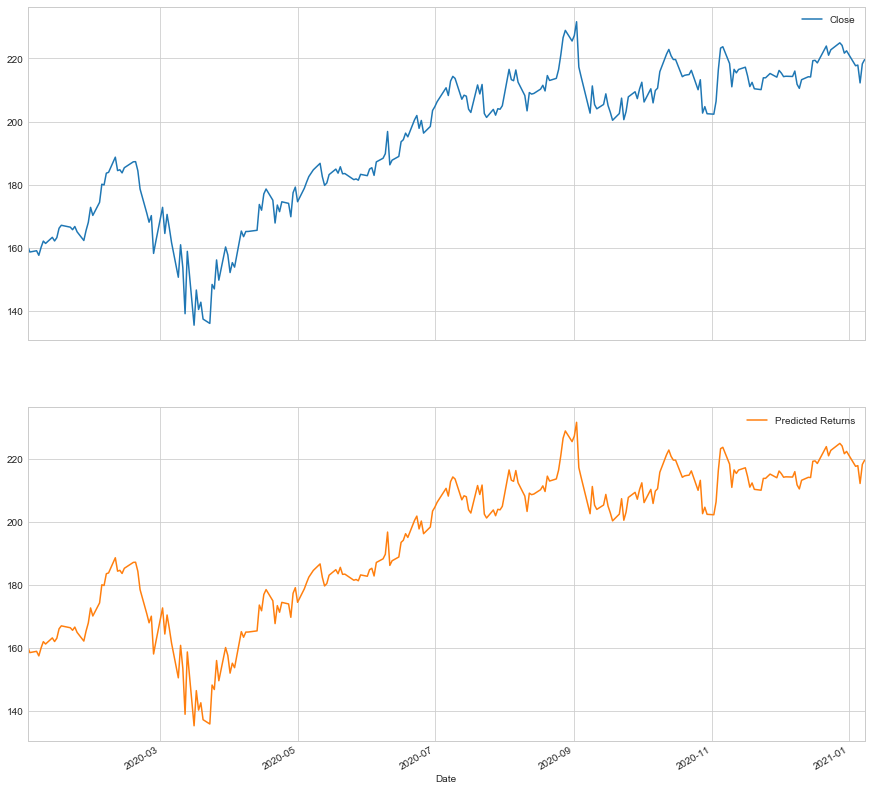

In [245]:
results.plot(subplots= True)

## Out-of-Sample Performance

In [248]:
from sklearn.metrics import mean_squared_error, r2_score
mse= mean_squared_error (results['Close'],
                        results['Predicted Returns'])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of_sample_rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 2.577861488362954e-07
